In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
from torch.utils.data.sampler import SubsetRandomSampler

In [3]:
normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]], std=[x/255.0 for x in [63.0, 62.1, 66.7]])
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

fashion_trainset = datasets.FashionMNIST(root='./fmnist/', train=True, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 12355072.98it/s]


Extracting ./fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209521.76it/s]


Extracting ./fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3904927.47it/s]


Extracting ./fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15795374.54it/s]

Extracting ./fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fmnist/FashionMNIST/raw



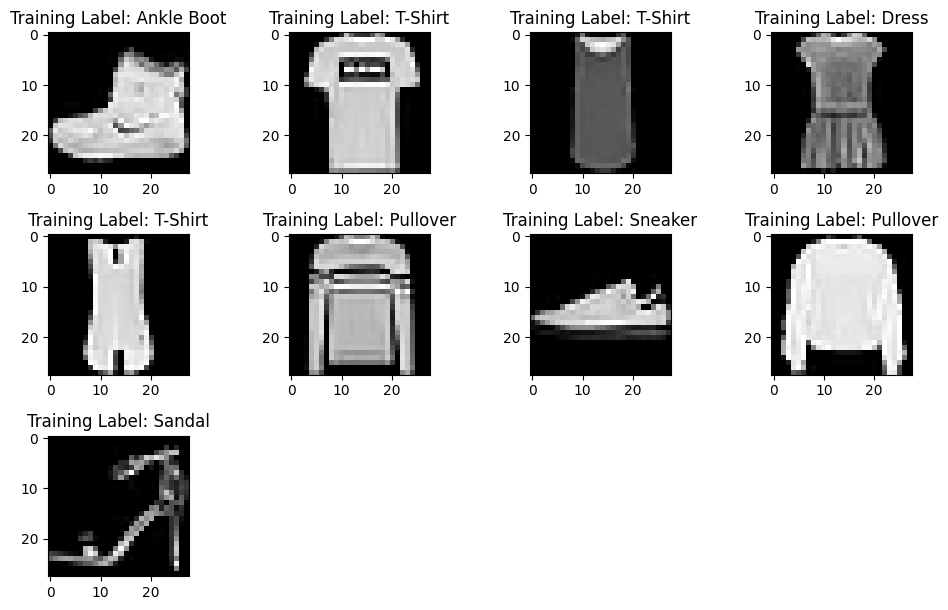

In [6]:
labels_map = ('T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt','Sneaker', 'Bag', 'Ankle Boot')
fig = plt.figure(figsize=(10, 10))
columns = 4
rows = 5
for i in range(1, 10):
  fig.add_subplot(rows, columns, i)
  fig.tight_layout()
  plt.imshow(fashion_trainset.train_data[i-1].numpy(), cmap='gray')
  plt.title(f'Training Label: {labels_map[fashion_trainset.train_labels[i-1]]}')
plt.show()

In [22]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(28*28, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 64)
    self.fc4 = nn.Linear(64, 32)
    self.fc5 = nn.Linear(32, 10)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = self.fc5(x)
    return x

In [23]:
MLP_network = MLP()

In [24]:
MLP_network

MLP(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(MLP_network.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08, weight_decay=0.001)

In [26]:
num_train = len(fashion_trainset)
indices = list(range(num_train))

split = 54000

train_idx = np.random.choice(indices, size=split, replace=False)
validation_idx = list(set(indices) - set(train_idx))

train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

train_loader1 = torch.utils.data.DataLoader(fashion_trainset, batch_size=16, sampler=train_sampler)
validation_loader1 = torch.utils.data.DataLoader(fashion_trainset, batch_size=16, sampler=validation_sampler)

In [27]:
num_epochs = 20
total_step = len(train_loader1)
loss_f1 = []
print('-'*20)

for epoch in range(num_epochs):
  running_loss = 0.0
  for i, data in enumerate(train_loader1, 0):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = MLP_network(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f"Epoch: {epoch + 1} | Loss: {running_loss/total_step}")

  loss_f1.append(running_loss / total_step)

print('Finished Training')


--------------------
Epoch: 1 | Loss: 0.530609313297051
Epoch: 2 | Loss: 0.4179582989789821
Epoch: 3 | Loss: 0.3851526829699675
Epoch: 4 | Loss: 0.3708054230952704
Epoch: 5 | Loss: 0.3637670783210132
Epoch: 6 | Loss: 0.35516652948740457
Epoch: 7 | Loss: 0.3507578623013364
Epoch: 8 | Loss: 0.34375882535013885
Epoch: 9 | Loss: 0.3429822639649113
Epoch: 10 | Loss: 0.33842035739786097
Epoch: 11 | Loss: 0.33700187152596534
Epoch: 12 | Loss: 0.33596292590349913
Epoch: 13 | Loss: 0.33221018779498557
Epoch: 14 | Loss: 0.3299353667318269
Epoch: 15 | Loss: 0.3290935681484364
Epoch: 16 | Loss: 0.32733680591897835
Epoch: 17 | Loss: 0.32800990520969586
Epoch: 18 | Loss: 0.3272973863692195
Epoch: 19 | Loss: 0.32619865903617057
Epoch: 20 | Loss: 0.32566454641686543
Finished Training


In [28]:
correct = 0
total = 0
with torch.no_grad():
  for data in validation_loader1:
    images, labels = data
    outputs = MLP_network(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
print(f"Accuracy: {100 * correct / total}")

Accuracy: 87.2


In [29]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in validation_loader1:
    images, labels = data
    outputs = MLP_network(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(10):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1

for i in range(10):
  print(f"Accuracy of Class {labels_map[i]} : {100 * class_correct[i] / class_total[i]}")



Accuracy of Class T-Shirt : 71.671388101983
Accuracy of Class Trouser : 96.33802816901408
Accuracy of Class Pullover : 78.06788511749347
Accuracy of Class Dress : 81.56424581005587
Accuracy of Class Coat : 87.27272727272727
Accuracy of Class Sandal : 96.52605459057072
Accuracy of Class Shirt : 71.27659574468085
Accuracy of Class Sneaker : 95.18716577540107
Accuracy of Class Bag : 95.30386740331491
Accuracy of Class Ankle Boot : 94.76309226932668


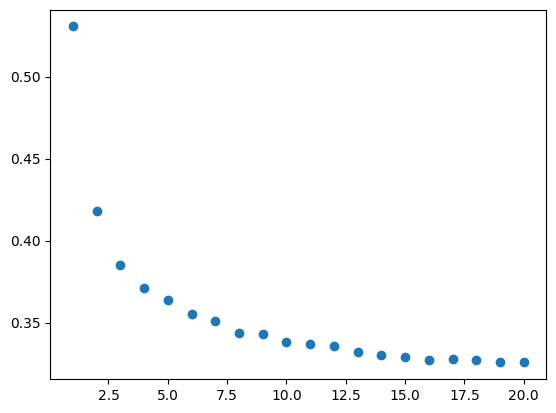

In [31]:
plt.scatter([x+1 for x in range(20)], loss_f1)